In addition to the packages below, this script requires fsl to be installed on computer...

In [1]:
%%capture
import numpy as np
from scipy import ndimage, stats, ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, image, input_data
from nilearn.image import load_img, index_img, new_img_like, resample_to_img, threshold_img
from nilearn.input_data import NiftiMasker
import rpy2
from scipy.stats import norm
import timeit
import seaborn as sns
import pandas as pd
from fast_histogram import histogram1d, histogram2d
from lmfit.models import SkewedGaussianModel

Create mask image in correct dimensions

In [2]:
colin_27_1mm_mask = load_img('data/colin_27_mask_1mm.nii.gz')
component_image = load_img('data/FUNCTIONAL_ICA_BRAINMAP_01.nii.gz')
resampled_colin27_img = resample_to_img(colin_27_1mm_mask, component_image)
resampled_colin27_img.to_filename('data/colin_27_mask_2mm.nii.gz')

#dilate mask
array = resampled_colin27_img.get_data()
dil_array = ndimage.binary_dilation(array)
resampled_colin27_img_dil = new_img_like(resampled_colin27_img, dil_array, affine=None, copy_header=True) 
resampled_colin27_img_dil.to_filename('data/colin_27_mask_2mm_dil.nii.gz')

Import fsl_smoothest function from fslr package

In [3]:
#import rpy2's package module
import rpy2.robjects.packages as rpackages

#import R's utility package
utils = rpackages.importr('utils')

#select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface.NULLType object at 0x7f925941f280> [RTYPES.NILSXP]

In [4]:
%%capture
utils.install_packages('fslr')

In [5]:
from rpy2.robjects.packages import importr
utils = importr("utils")
fslr = importr("fslr")
fsl_smoothest = rpy2.robjects.r['fsl_smoothest']

Load functional/vbm components and estimate their smoothness

In [6]:
%%capture
smoothing_values = [];
for i in range(1,21):
    if i < 10:
        smooth_est = fsl_smoothest(z_image = 'data/FUNCTIONAL_ICA_BRAINMAP_0' + str(i) + '.nii.gz', file = 'data/colin_27_mask_2mm_dil.nii.gz')
        smoothing_values.append(float(smooth_est[16].split(" ")[2]))
        smoothing_values.append(float(smooth_est[16].split(" ")[6]))
        smoothing_values.append(float(smooth_est[16].split(" ")[10]))
    else:
        smooth_est = fsl_smoothest(file = 'data/colin_27_mask_2mm_dil.nii.gz', z_image = 'data/FUNCTIONAL_ICA_BRAINMAP_' + str(i) + '.nii.gz') 
        smoothing_values.append(float(smooth_est[16].split(" ")[2]))
        smoothing_values.append(float(smooth_est[16].split(" ")[6]))
        smoothing_values.append(float(smooth_est[16].split(" ")[10]))

In [7]:
print("Functional Smoothing Mean Estimate (FWHMxyz voxels): " + str(np.mean(np.array(smoothing_values))))
print("Functional Smoothing Median Estimate (FWHMxyz voxels): " + str(np.median(np.array(smoothing_values))))
func_mean = np.mean(np.array(smoothing_values))

Functional Smoothing Mean Estimate (FWHMxyz voxels): 10.183529000000002
Functional Smoothing Median Estimate (FWHMxyz voxels): 9.98518


In [8]:
%%capture
smoothing_values = [];
for i in range(1,21):
    if i < 10:
        smooth_est = fsl_smoothest(file = "data/colin_27_mask_2mm_dil.nii.gz", z_image = "data/VBM_ICA_BRAINMAP_0" + str(i) + ".nii.gz")
        smoothing_values.append(float(smooth_est[16].split(" ")[2]))
        smoothing_values.append(float(smooth_est[16].split(" ")[6]))
        smoothing_values.append(float(smooth_est[16].split(" ")[10]))
    elif i == 19:
        print("Skip IC-19")
    else:
        smooth_est = fsl_smoothest(file = "data/colin_27_mask_2mm_dil.nii.gz", z_image = "data/VBM_ICA_BRAINMAP_" + str(i) + ".nii.gz") 
        smoothing_values.append(float(smooth_est[16].split(" ")[2]))
        smoothing_values.append(float(smooth_est[16].split(" ")[6]))
        smoothing_values.append(float(smooth_est[16].split(" ")[10]))

In [9]:
print("VBM Smoothing Mean Estimate (FWHMxyz voxels): " + str(np.mean(np.array(smoothing_values))))
print("VBM Smoothing Median Estimate (FWHMxyz voxels): " + str(np.median(np.array(smoothing_values))))

VBM Smoothing Mean Estimate (FWHMxyz voxels): 9.06671894736842
VBM Smoothing Median Estimate (FWHMxyz voxels): 8.96943


Create null distribution of correlation coefficients of simulated vbm vs. func images

In [10]:
#set desired iteration value
ITERATIONS = 1

In [11]:
#correlate simulated functional noise images with real vbm images

#CHANGE VOXEL SIZE TO MM (times 2, python thinks mask image is 1x1x1mm)

masker = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz", sessions=None, smoothing_fwhm=func_mean*2, standardize=False, detrend=False, low_pass=None, high_pass=None, t_r=None, target_affine=None, target_shape=None, mask_strategy='background', mask_args=None, sample_mask=None, dtype=None, memory_level=1, verbose=0)
masker_no_smooth = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz", sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, low_pass=None, high_pass=None, t_r=None, target_affine=None, target_shape=None, mask_strategy='background', mask_args=None, sample_mask=None, dtype=None, memory_level=1, verbose=0)

x = 80 #x dimension
y = 96 #y dimension
z = 70 #z dimension

start_time = timeit.default_timer()

null_cors = []; #stores null statistic for each iteration

real_vbm = load_img("data/VBM_ICA.nii.gz")
image_rand_func = np.zeros((x,y,z,20)) #20 is 4-d direction, 20 functional images

for i in range(0,ITERATIONS):
    print(str(i), flush=True)
    null_cors_iter = [];
    for j in range(0,20):
        image_rand_func[:,:,:,j] = np.random.normal(0, 5, size=(x, y, z))
    
    noise_im_func = new_img_like(real_vbm, image_rand_func, affine=None, copy_header=True) 
    noise_im_func = masker.fit_transform(noise_im_func)
    real_vbm_data = masker_no_smooth.fit_transform(real_vbm)

    for j in range(0,20):
        for k in range(0,20):
            if k != 18: #Ignore artifactual component #19, k=18
                null_cors_iter.append(np.corrcoef(noise_im_func[j,:],real_vbm_data[k,:])[0,1])
    
    null_cors.append(max(np.abs(null_cors_iter))) #find maxmium (absolute value) correlation of iteration 
    
elapsed = timeit.default_timer() - start_time
print("Time to run: " + str(elapsed) + " seconds for " + str(i+1) + " iterations")


0
Time to run: 1.9437583450000027 seconds for 1 iterations


Save output

In [12]:
#save output
# str_name = "1000_iter_11-18-2019.npy"
# np.save(str_name, np.array(null_cors))

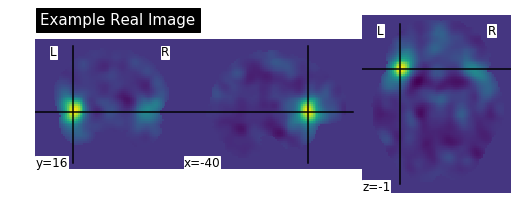

In [13]:
#load output
null_cors = np.load("1000_iter_11-18-2019.npy")

real_im_ex = masker_no_smooth.inverse_transform(real_vbm_data)
x = index_img(real_im_ex,2)
plotting.plot_img(x,title="Example Real Image")

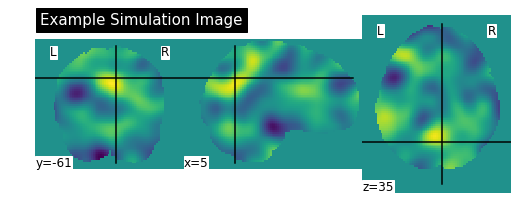

In [14]:
noise_im_func_ex = masker.inverse_transform(noise_im_func)
x = index_img(noise_im_func_ex,1)
plotting.plot_img(x,title="Example Simulation Image")

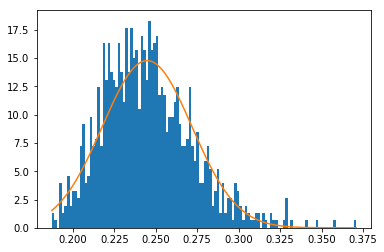

In [22]:
hist,bins = np.histogram(null_cors,bins=120)
plt.hist(null_cors,bins,normed=True)

null_cors_ar = np.array(null_cors)
null_cors_ar[null_cors_ar>0.10]
xmin, xmax = min(null_cors_ar), max(null_cors_ar)
lnspc = np.linspace(xmin,xmax, len(null_cors_ar))

(mu,sigma) = norm.fit(null_cors_ar)
pdf_g = stats.norm.pdf(lnspc,mu,sigma)
plt.plot(lnspc,pdf_g,label="Normed")

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 120
    # variables        = 4
    chi-square         = 748.030608
    reduced chi-square = 6.44853972
    Akaike info crit   = 227.594258
    Bayesian info crit = 238.744225
[[Variables]]
    amplitude:  1.53267453 +/- 0.03731386 (2.43%) (init = 0.6)
    center:     0.21565570 +/- 0.00155201 (0.72%) (init = 0.22)
    sigma:      0.03817014 +/- 0.00204885 (5.37%) (init = 0.02)
    gamma:      2.09429028 +/- 0.35054784 (16.74%) (init = 3)
    height:     16.0190338 +/- 0.80521251 (5.03%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
    fwhm:       0.08988380 +/- 0.00482468 (5.37%) == '2.3548200*sigma'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.879
    C(sigma, gamma)      =  0.845
    C(center, gamma)     = -0.836
    C(amplitude, sigma)  =  0.362
    C(amplitude, center) = -0.237


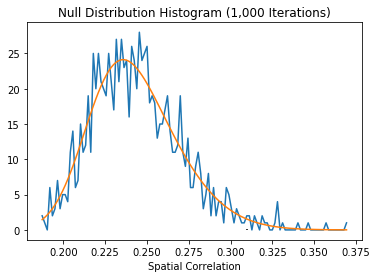

In [23]:
#fit null distribution to skewed gaussian instead
model = SkewedGaussianModel()

bins = bins[0:len(bins)-1]

#set initial parameter values
params = model.make_params(amplitude=0.6, center=0.22, sigma=0.02, gamma=3)

#adjust parameters  to best fit data.
result = model.fit(hist, params, x=bins)

print(result.fit_report())
plt.plot(bins,hist)
plt.plot(bins, result.best_fit) 
plt.title("Null Distribution Histogram (1,000 Iterations)")
plt.xlabel("Spatial Correlation")
plt.vlines(x=0.31,ymin=0,ymax=0.20)

Find P-value 

In [20]:
#set r threshold value
r_threshold_value = 0.30

In [29]:
res = next(x for x, val in enumerate(bins) if val > r_threshold_value) #find histogram index of r_threshold

total = 0 #total iterations
total_after = 0 #total iterations with simulated r > threshold r

#sum over entire histogram (i.e., number of iterations)
for ele in range(0, len(bins)):
    total = total + hist[ele]
    

#sum histogram after r_threshold
for ele in range(res, len(bins)):
    total_after = total_after + hist[ele]
    
p_value = total_after/total

print("P-value: " + str(p_value))
print("Total iterations: " + str(total))

P-value: 0.032
Total iterations: 1000


Calculate real correlation matrix of data

In [22]:
functional_ica = load_img("data/FUNCTIONAL_ICA.nii.gz")
vbm_ica = load_img("data/VBM_ICA.nii.gz")

In [23]:
masker_no_smooth = NiftiMasker(mask_img="data/colin_27_mask_2mm_dil.nii.gz", sessions=None, smoothing_fwhm=None, standardize=False, detrend=False, low_pass=None, high_pass=None, t_r=None, target_affine=None, target_shape=None, mask_strategy='background', mask_args=None, sample_mask=None, dtype=None, memory_level=1, verbose=0)

cor_mat = np.zeros((20,20))

func_im = masker_no_smooth.fit_transform(functional_ica)
vbm_im = masker_no_smooth.fit_transform(vbm_ica)
        
for i in range(0,20):
    for j in range(0,20):
        if j != 18: #Ignore artifactual component #19, k=18
            cor_mat[i,j] = np.corrcoef(func_im[i,:],vbm_im[j,:])[0,1]

In [25]:
df = pd.DataFrame(data=cor_mat)

df.columns = ['VBM-01','VBM-02','VBM-03','VBM-04','VBM-05','VBM-06','VBM-07','VBM-08','VBM-09','VBM-10','VBM-11','VBM-12','VBM-13','VBM-14','VBM-15','VBM-16','VBM-17','VBM-18','VBM-19','VBM-20']

#remove column 19
df = df.drop(['VBM-19'], axis=1)

df.rename(index={0:'FUNC-01',1:'FUNC-02',2:'FUNC-03',3:'FUNC-04',4:'FUNC-05',5:'FUNC-06',6:'FUNC-07',7:'FUNC-08',8:'FUNC-09',9:'FUNC-10',10:'FUNC-11',11:'FUNC-12',12:'FUNC-13',13:'FUNC-14',14:'FUNC-15',15:'FUNC-16',16:'FUNC-17',17:'FUNC-18',18:'FUNC-19',19:'FUNC-20'}, inplace=True)

#sort by max column/row
df = df.loc[:, df.max().sort_values(ascending=False).index]
maxValuesObj = df.max(axis=1)
maxValuesObj = maxValuesObj.sort_values(ascending=False)
list_max = maxValuesObj.index.tolist()
df = df.loc[list_max,:]

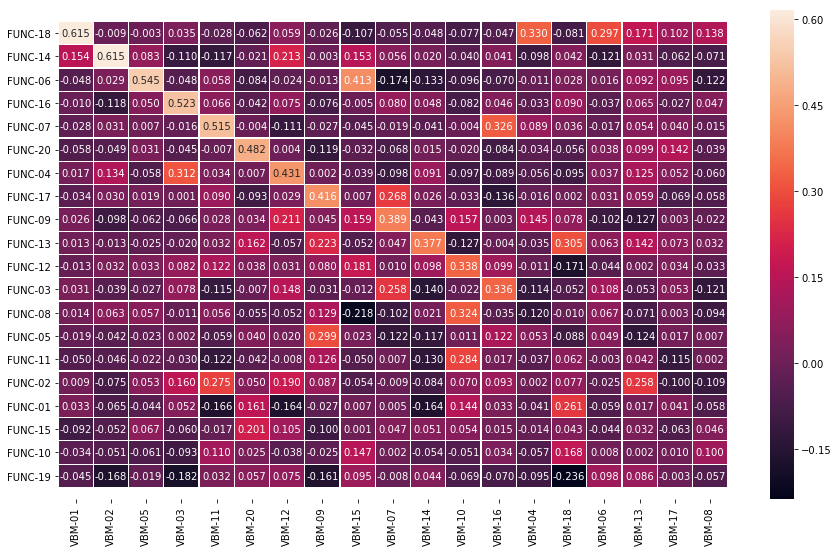

In [26]:
fig, ax = plt.subplots(figsize=(15,9))  
ax = sns.heatmap(df, linewidth=0.2, annot=True, fmt=".3f")

#fixes heatmap bug
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!